In [33]:
!python3 --version
!pip freeze | grep qiskit
from qiskit.visualization import plot_histogram
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms import TimeEvolutionProblem, TrotterQRTE
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit.primitives import Estimator
import numpy as np

Python 3.12.3
qiskit==1.1.0
qiskit-algorithms==0.3.0
qiskit-nature==0.7.2


The Fauseweh-Zhu paper [here](https://arxiv.org/pdf/2112.04276).

Optimization library in
- [Julia](https://julianlsolvers.github.io/Optim.jl/stable/algo/linesearch/)
- [Python](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html) (BFGS)

- [TrotterQRTE](https://docs.quantum.ibm.com/api/qiskit/0.46/qiskit.algorithms.time_evolvers.trotterization.TrotterQRTE) for time evolution - now in Qiskit Nature
- Using [estimator](https://docs.quantum.ibm.com/api/qiskit/0.46/qiskit.primitives.Estimator) to measure expectation
- Try [ground state solver](https://qiskit-community.github.io/qiskit-nature/tutorials/03_ground_state_solvers.html) from qiskit nature for optimisation.

Optimise by (if not deprecated):
- [Conjugate gradient](https://docs.quantum.ibm.com/api/qiskit/0.26/qiskit.algorithms.optimizers.CG)
- [Truncated descent](https://docs.quantum.ibm.com/api/qiskit/0.26/qiskit.algorithms.optimizers.CG)

In [26]:
chain_length = 4

num_layers = 1

shots = 2000
num_time_steps = 10

In [ ]:
parameter_space_size = 2 * chain_length + 3 * chain_length * num_layers

param_space = [0]*parameter_space_size

theta = Parameter('θ')

In [ ]:
def ansatz_circuit_0(qc, param_space):
    # layer 0
    for i in range(chain_length):
        qc.rx(param_space[param_counter],i)
        param_counter=param_counter+1
        qc.rz(param_space[param_counter],i)
        param_counter=param_counter+1
    
def ansatz_circuit_1(qc, param_space):
    param_counter = 2 * chain_length
    for i in range(chain_length-1):
        qc.cx(i,i+1)
    qc.cx(-1,0)
    for i in range(chain_length):
        qc.rz(param_space[param_counter],i)
        param_counter=param_counter+1
        qc.rx(param_space[param_counter],i)
        param_counter=param_counter+1
        qc.rz(param_space[param_counter],i)

def create_ansatz_circuit(qc, num_layers=num_layers, param_space=param_space):
    ansatz_circuit_0(qc, param_space)
    for i in range(num_layers):
        ansatz_circuit_1(qc, param_space)

def ansatz_circuit_ladder(qc, param_space):
    register_size = chain_length*2
    # layer 0
    param_counter = 0
    for i in range(register_size):
        qc.rx(param_space[param_counter],i)
        param_counter=param_counter+1
    for i in range(register_size):
        qc.rz(param_space[param_counter],i)
        param_counter=param_counter+1
    for i in range(1,register_size//2):
        place = 2 * i - 1
        qc.cx(place,place+1)
    # qc.cx(-1,0)

def simulate(qc, shots=shots):
    initial_state = Statevector.from_instruction(qc)
    display(initial_state.draw())
    ham = hamiltonian(0)
    evolved_state = evolve(ham,qc)

def evolve(ham, initial_state, num_time_steps=num_time_steps):
    time=1
    evolution = TrotterQRTE(num_timesteps=num_time_steps)
    evolution_problem = TimeEvolutionProblem(ham, initial_state, time)
    evolution_result = evolution.evolve(evolution_problem)
    return evolution_result.evolved_state

def hamiltonian(t, J=1, A=2, Ω=2.5):
    creator = ['I']*chain_length
    paulis = ['I','X','Y','Z']
    ham = [] # [('X',1.0)]
    for i in range(chain_length-1):
        for j in range(1,4):
            op = creator[:]
            op[i] = paulis[j]
            op[i+1] = paulis[j]
            ham.append([''.join(op), -J/4])
    for i in range(chain_length):
        op1, op2 = creator[:], creator[:]
        op1[i] = 'X'
        op2[i] = 'Y'
        ham.append([''.join(op1), A * np.cos(Ω*t)])
        ham.append([''.join(op2), A * np.sin(Ω*t)])
    ham = np.array(ham)
    return SparsePauliOp(ham[:,0], ham[:,1])

def time_evolver(qc, ham, time=1):
    initial_state = Statevector.from_instruction(qc)
    return initial_state

In [29]:
print(hamiltonian(0))

SparsePauliOp(['XXII', 'YYII', 'ZZII', 'IXXI', 'IYYI', 'IZZI', 'IIXX', 'IIYY', 'IIZZ', 'XIII', 'YIII', 'IXII', 'IYII', 'IIXI', 'IIYI', 'IIIX', 'IIIY'],
              coeffs=[-0.25+0.j, -0.25+0.j, -0.25+0.j, -0.25+0.j, -0.25+0.j, -0.25+0.j,
 -0.25+0.j, -0.25+0.j, -0.25+0.j,  2.  +0.j,  0.  +0.j,  2.  +0.j,
  0.  +0.j,  2.  +0.j,  0.  +0.j,  2.  +0.j,  0.  +0.j])


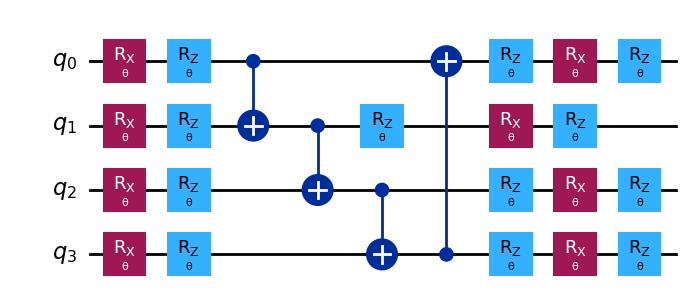

In [30]:
qc = QuantumCircuit(chain_length)

# qc.h(qc.qubits)

create_ansatz_circuit(qc)

# qc.measure_all()

qc.draw('mpl')

# print(time_evolver(qc, hamiltonian(0)))

In [31]:
simulate(qc)

TypeError: ParameterExpression with unbound parameters (dict_keys([Parameter(θ)])) cannot be cast to a float.